In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

from transformers import AutoModelForSequenceClassification, AutoTokenizer

from tqdm.notebook import tqdm


In [ ]:
# Path to your saved model
model_path = "../models/indobert-hoax"

# Load model and tokenizer locally
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)

# Move model to appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded successfully on {device}")


Model loaded successfully on cpu


: 

In [ ]:
# Load dataset
df = pd.read_csv("../cleandata/hoax_dataset_merged.csv")
df = df.dropna(subset=["cleaned", "label"])

# Balance dataset (same logic as training)
hoax_df = df[df["label"] == 1]
valid_df = df[df["label"] == 0].sample(n=len(hoax_df), random_state=42)
df_balanced = pd.concat([hoax_df, valid_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# Split again with same ratio
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced["cleaned"].tolist(),
    df_balanced["label"].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize test set
encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# Wrap as Dataset class
class HoaxDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

# Create test dataset object
test_dataset = HoaxDataset(encodings, test_labels)


: 

In [ ]:
# Make sure the model is in eval mode
model.eval()

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=16)

# Store predictions and labels
predictions = []
true_labels = []

# Disable gradient calculation (faster)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        # Move to CPU (you can adapt to GPU if available)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

# Calculate metrics
acc = accuracy_score(true_labels, predictions)
prec = precision_score(true_labels, predictions)
rec = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

# Print results
print("=== Evaluation Results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")


Evaluating:   0%|          | 0/238 [00:00<?, ?it/s]

=== Evaluation Results ===
Accuracy : 0.9905
Precision: 0.9868
Recall   : 0.9942
F1 Score : 0.9905


: 

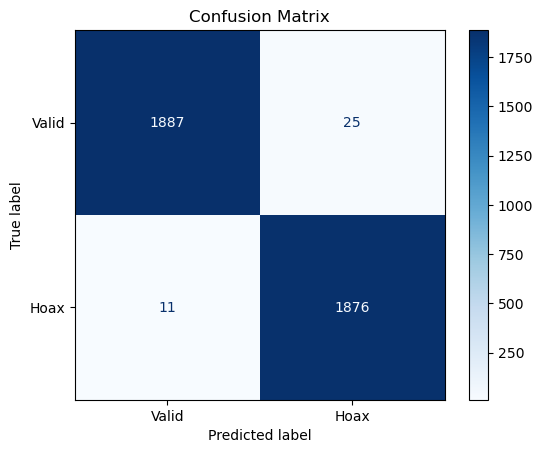

: 

: 

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Valid", "Hoax"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Print classification report
report = classification_report(true_labels, predictions, target_names=["Valid", "Hoax"])
print("=== Classification Report ===")
print(report)


=== Classification Report ===
              precision    recall  f1-score   support

       Valid       0.99      0.99      0.99      1912
        Hoax       0.99      0.99      0.99      1887

    accuracy                           0.99      3799
   macro avg       0.99      0.99      0.99      3799
weighted avg       0.99      0.99      0.99      3799



: 

: 

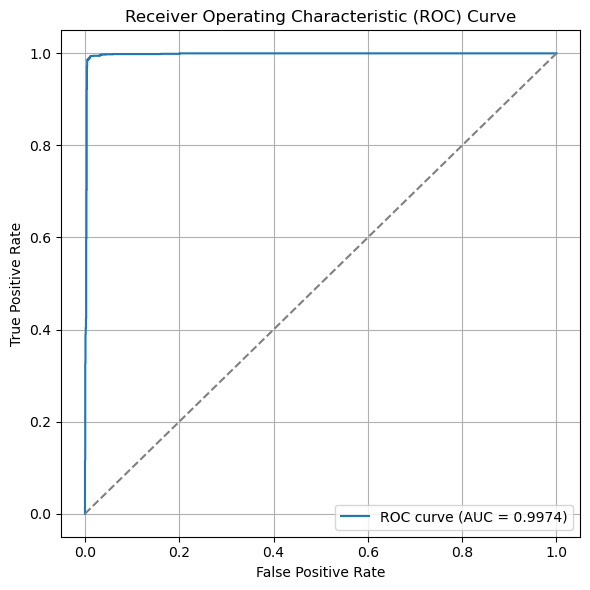

: 

: 

In [ ]:
# Collect probabilities for class 1 (Hoax)
probs = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prob = torch.softmax(logits, dim=1)[:, 1]  # class 1 = Hoax
        probs.extend(prob.cpu().numpy())

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
